# Layer Fusion

Layer fusion related computations are listed in this notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import OrderedDict
from functools import reduce
import layer_fusion_utils as utils

## Convolution Block

In [5]:
ConvLayer = utils.ConvLayer

In [6]:
def create_stacked_block(H, W, C, K):
    return [
        ConvLayer("conv1", H, W, C, C, K, "standard"),
        ConvLayer("conv2", H - K + 1, W - K + 1, C, C, K, "standard")
    ]

def create_depthwise_separable_block(H, W, C, F, K):
    return [
        ConvLayer("conv1", H, W, C, C, K, "depthwise"),
        ConvLayer("conv2", H, W, C, F, 1, "pointwise")
    ]
def create_bottleneck_block(H, W, C, F, K):
    return [
        ConvLayer("conv1", H, W, C, F, 1, "pointwise"),
        ConvLayer("conv2", H, W, F, F, K, "standard"),
        ConvLayer("conv3", H - K + 1, W - K + 1, F, C, 1, "pointwise")
    ]
def create_separable_bottleneck_block(H, W, C, F, K):
    return [
        ConvLayer("conv1", H, W, C, F, 1, "pointwise"),
        ConvLayer("conv2", H, W, F, F, K, "depthwise"),
        ConvLayer("conv3", H, W, F, C, 1, "pointwise")
    ]

In [7]:
create_depthwise_separable_block(56, 56, 256, 256, 3)

[               conv1: < 56,  56,  256,  256, 3,  depthwise>,
                conv2: < 56,  56,  256,  256, 1,  pointwise>]

In [8]:
create_bottleneck_block(56, 56, 256, 256, 3)

[               conv1: < 56,  56,  256,  256, 1,  pointwise>,
                conv2: < 56,  56,  256,  256, 3,   standard>,
                conv3: < 54,  54,  256,  256, 1,  pointwise>]

In [9]:
create_separable_bottleneck_block(56, 56, 256, 256, 3)

[               conv1: < 56,  56,  256,  256, 1,  pointwise>,
                conv2: < 56,  56,  256,  256, 3,  depthwise>,
                conv3: < 56,  56,  256,  256, 1,  pointwise>]

## Baseline Result

In [10]:
class BaselineModel:
    def get_cycles(self, block, params, seqs):
        num_cycles = 0
        for layer in block:
            param = params[layer.name]
            if layer.T == "standard" or layer.T == "pointwise":
                num_cycles += layer.H * layer.W * layer.C * layer.F / (param["P_W"] * param["P_C"] * param["P_F"])
            elif layer.T == "depthwise":
                num_cycles += layer.H * layer.W * layer.C / (param["P_W"] * param["P_C"])
        return num_cycles

    def get_resources(self, block, params, seqs):
        num_mults = 0
        for layer in block:
            param = params[layer.name]
            if layer.T == "standard":
                num_mults += param["P_W"] * param["P_C"] * param["P_F"] * (layer.K ** 2)
            elif layer.T == "depthwise":
                num_mults += param["P_W"] * param["P_C"] * (layer.K ** 2)
            elif layer.T == "pointwise":
                num_mults += param["P_W"] * param["P_C"] * param["P_F"]
        return num_mults

In [11]:
model = BaselineModel()
model.get_cycles(
    create_depthwise_separable_block(56, 56, 256, 256, 3),
    {"conv1": {"P_W": 1, "P_C": 1}, "conv2": {"P_W": 1, "P_C": 1, "P_F": 1}},
    None)

206323712.0

In [12]:
model.get_cycles(
    create_bottleneck_block(56, 56, 256, 256, 3),
    {"conv1": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv2": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv3": {"P_W": 1, "P_C": 1, "P_F": 1}},
    None)

602144768.0

In [13]:
model.get_cycles(
    create_separable_bottleneck_block(56, 56, 256, 256, 3),
    {"conv1": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv2": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv3": {"P_W": 1, "P_C": 1, "P_F": 1}},
    None)

411844608.0

In [14]:
def factors(n):
    return [i for i in range(1, n+1) if n % i == 0]

def to_params(block, prod):
    idx = 0
    params = OrderedDict()
    for layer in block:
        if layer.T == "depthwise":
            params[layer.name] = {"P_W": prod[idx], "P_C": prod[idx+1]}
            idx += 2
        elif layer.T == "pointwise" or layer.T == "standard":
            params[layer.name] = {"P_W": prod[idx], "P_C": prod[idx+1], "P_F": prod[idx+2]}
            idx += 3
    return params

def validate(block, params):
    is_P_W_valid = reduce(lambda x, y: x and params[y.name]["P_W"] == params[block[0].name]["P_W"],
                          block)
    is_P_C_F_valid = True
    for idx, layer in enumerate(block):
        if idx > 0 and params[layer.name]["P_C"] != params[block[idx-1].name]["P_C"]:
            is_P_C_F_valid = False
            break
    
    return is_P_W_valid and is_P_C_F_valid
    

def resolve_block(block, max_mults):
    model = BaselineModel()
    block_param_cand = []
    for layer in block:
        if layer.T == "depthwise":
            block_param_cand.extend([[1, 2], factors(layer.C)])
        elif layer.T == "pointwise" or layer.T == "standard":
            block_param_cand.extend([[1, 2], factors(layer.C), factors(layer.F)])

    results = []
    products = list(itertools.product(*block_param_cand))
    for idx, prod in enumerate(products):
        params = to_params(block, prod)
        # all P_W should equal
        if not validate(block, params):
            continue
        num_mults = model.get_resources(block, params, None)
        if num_mults >= max_mults:
            continue
        num_cycles = model.get_cycles(block, params, None)
        results.append([num_cycles, num_mults, params, None])
    
    return results

In [15]:
results = [
    resolve_block(create_depthwise_separable_block(56, 56, 256, 256, 3), 1963),
    resolve_block(create_bottleneck_block(56, 56, 256, 256, 3), 1963),
    resolve_block(create_separable_bottleneck_block(56, 56, 256, 256, 3), 1963)
]

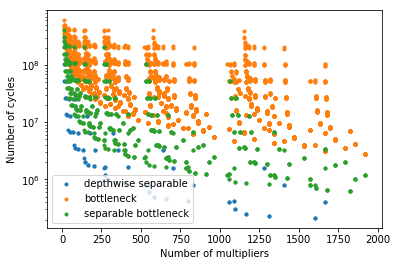

In [16]:
xss = []
yss = []
for result in results:
    xss.append([x[1] for x in result])
    yss.append([x[0] for x in result])
    
plt.scatter(xss[0], yss[0], marker='.', label='depthwise separable')
plt.scatter(xss[1], yss[1], marker='.', label='bottleneck')
plt.scatter(xss[2], yss[2], marker='.', label='separable bottleneck')

plt.xlabel('Number of multipliers')
plt.ylabel('Number of cycles')
plt.yscale('log')
plt.legend()

## Dataflow Model

Let's evaluate the dataflow model.

### An Example on Depthwise Separable Convolution

In [17]:
def depthwise_tick_to_state(tick, H, W, C, F=None, seq=None):
    n = int(math.floor(tick / (H * W * C)))
    tick -= n * H * W * C
    c = int(math.floor(tick / (H * W)))
    h = int(math.floor((tick - c * H * W) / W))
    w = int(tick - c * H * W - h * W)
    return c, h, w

def pointwise_tick_to_state(tick, H, W, C, F, seq):
    n = int(math.floor(tick / (H * W * C * F)))
    tick -= n * H * W * C * F
    if seq == "filter":
        f = int(math.floor(tick / (H * W * C)))
        tick = int(tick - f * H * W * C)
        c = int(math.floor(tick / (H * W)))
        tick = int(tick - c * H * W)
    elif seq == "channel":
        c = int(math.floor(tick / (F * H * W)))
        tick = int(tick - c * H * W * F)
        f = int(math.floor(tick / (H * W)))
        tick = int(tick - f * H * W)
    h = int(math.floor(tick / W))
    w = int(tick - h * W)
    return f, c, h, w

def get_depthwise_output_addr(state, next_seq, H, W, K, P_W):
    k = int(math.floor(K / 2))
    c, h, w = state
    h = 0 if h < K - 1 else h - K + 1
    w = 0 if w * P_W < K - 1 else int((w * P_W - K + 1) / P_W)
    return int(c * H * W + h * W + w)
    
def get_pointwise_input_addr(state, seq, H, W):
    f, c, h, w = state
    return int(c * H * W + h * W + w)

def depthwise_separable_dataflow(N, block, params, seqs, use_double_buffer=True):
    t = 0
    bts = np.zeros(len(block)) # tick for each block layer
    state = np.zeros(len(block))
    depth, point = block[0], block[1]
    H, W, C, F, K = depth.H, depth.W, depth.C, point.F, depth.K
    OH = H - K + 1
    OW = W - K + 1
    P_W, P_C, P_F = params[depth.name]['P_W'], params[depth.name]['P_C'], params[point.name]['P_F']
    buf_num_addr = int(H * W * C / (P_W * P_C))
    
    # double buffer
    # each state is (is_readable, is_writable)
    buf_state = np.array([
        np.vstack([np.zeros(buf_num_addr), np.ones(buf_num_addr)]).T,
        np.vstack([np.zeros(buf_num_addr), np.ones(buf_num_addr)]).T
    ], dtype=np.bool)
    
    read_buf, write_buf = 0, 0
    output_points = []
    batch = 0
    while True:
        state = [depthwise_tick_to_state(bts[0], H, int(W/P_W), int(C/P_C)),
                 pointwise_tick_to_state(bts[1], OH, int(OW/P_W), int(C/P_C), int(F/P_F), seqs[1])]
        output_addr = get_depthwise_output_addr(state[0], seqs[1], OH, int(OW/P_W), K, P_W)
        input_addr = get_pointwise_input_addr(state[1], seqs[1], OH, int(OW/P_W))
        
        # update buffer state
        write_buf_state = buf_state[write_buf]
        if write_buf_state[output_addr][1]: # writable?
            if state[0][1] >= K - 1 and state[0][2] * P_W >= (K + P_W - 2): # result ready?
                write_buf_state[output_addr][0] = True # readable
                write_buf_state[output_addr][1] = False # not writable
                # print("WRITE:", write_buf_state[output_addr])
            bts[0] += 1
            
        read_buf_state = buf_state[read_buf]
        if read_buf_state[input_addr][0]: # readable?
            # when to release
            if state[1][0] == int(F/P_F) - 1: # release?
                read_buf_state[input_addr][0] = False # not readable
                read_buf_state[input_addr][1] = True # writable
                # print("READ:", read_buf_state[input_addr])
            bts[1] += 1
        
        if use_double_buffer:
            if state[0][0] == int(C/P_C) - 1 and state[0][1] == int(H) - 1 and state[0][2] == int(W/P_W) - 1:
                write_buf = int(1 - write_buf)
                
            if (state[1][0] == int(F/P_F) - 1 and
                state[1][1] == int(C/P_C) - 1 and
                state[1][2] == int(OH) - 1 and
                state[1][3] == int(OW/P_W) - 1):
                read_buf = int(1 - read_buf)
                
            
        if (state[1][0] == int(F/P_F) - 1 and
            state[1][1] == int(C/P_C) - 1 and
            state[1][2] == int(OH) - 1 and
            state[1][3] == int(OW/P_W) - 1):
            output_points.append(t)
            if batch == N - 1:
                break
            batch += 1
        
        # print(batch, bts, state, output_addr, input_addr, write_buf, read_buf)
        t += 1
    
    return output_points

seqs = ["filter", "channel"]
use_double_buffer = [True, False]
channel_larger = [True, False]
for cl, seq, udb in itertools.product(channel_larger, seqs, use_double_buffer):
    CC = 16 if cl else 2
    FF = 2 if cl else 16 
    result = depthwise_separable_dataflow(10, create_depthwise_separable_block(4, 4, CC, FF, 3),
                                          {"conv1": {"P_W": 1, "P_C": 1}, "conv2": {"P_W": 1, "P_C": 1, "P_F": 1}},
                                          ["filter", seq],
                                          use_double_buffer=udb)
    throughput = result[-1] - result[-2]
    print("%10s %10s %10s %10d %s" % (cl, seq, udb, throughput, result))

      True     filter       True        256 [319, 575, 831, 1087, 1343, 1599, 1855, 2111, 2367, 2623]
      True     filter      False        257 [319, 576, 833, 1090, 1347, 1604, 1861, 2118, 2375, 2632]
      True    channel       True        256 [259, 515, 771, 1027, 1283, 1539, 1795, 2051, 2307, 2563]
      True    channel      False        256 [259, 515, 771, 1027, 1283, 1539, 1795, 2051, 2307, 2563]
     False     filter       True        128 [151, 279, 407, 535, 663, 791, 919, 1047, 1175, 1303]
     False     filter      False        145 [151, 296, 441, 586, 731, 876, 1021, 1166, 1311, 1456]
     False    channel       True        128 [139, 267, 395, 523, 651, 779, 907, 1035, 1163, 1291]
     False    channel      False        128 [139, 267, 395, 523, 651, 779, 907, 1035, 1163, 1291]


### A General Case

We use `run_dataflow_sim` to simulate the execution process.

#### Bottleneck Block Example

In this example, we show that for a typical ResNet bottleneck block,
`F-C-F` can achieve higher performance.

In [52]:
SEQ = [utils.FILTER, utils.CHANNEL]
def encode_seq(seq):
    return ''.join([s[0].upper() for s in seq])
SEQS = list(itertools.product(SEQ, SEQ, SEQ))
df = pd.DataFrame(columns=['SEQ', 'Cycles', 'Throughput', 'IsBufInput', 'BufferSize'])

P_Ws = [1]
P_C0s = [64]
P_C1s = [32]
P_C2s = [32]
P_Fs = [64]
PPs = list(itertools.product(P_Ws, P_C0s, P_C1s, P_C2s, P_Fs))

blocks = [
    create_bottleneck_block(56, 56, 256, 64, 3),
]
for is_buf_input in [True, False]:
    for block in blocks:
        for seq in SEQS:
            for P_W, P_C0, P_C1, P_C2, P_F in PPs:
                r = utils.run_dataflow_sim(3,
                                       block,
                                       {"conv1": {"P_W": P_W, "P_C": P_C0, "P_F": P_C1},
                                        "conv2": {"P_W": P_W, "P_C": P_C1, "P_F": P_C2},
                                        "conv3": {"P_W": P_W, "P_C": P_C2, "P_F": P_F}},
                                       seq,
                                       is_buf_input=is_buf_input)

                throughput = r[0][-1] - r[0][-2]
                buffer_size = r[1] * 32 / 8 / 1024
                df = df.append(
                    pd.DataFrame([[encode_seq(seq), r[0][-1], throughput, is_buf_input, buffer_size]],
                                 columns=['SEQ', 'Cycles', 'Throughput', 'IsBufInput', 'BufferSize']),
                    ignore_index=True)
            print("%s %e %10d %s" % (encode_seq(seq), buffer_size, throughput, r[0]))

FFF 1.513000e+03      25089 [48854, 73943, 99032]
FFC 1.148500e+03      30922 [45939, 76861, 107783]
FCF 1.121000e+03      30482 [45719, 76201, 106683]
FCC 7.565000e+02      33178 [45499, 78677, 111855]
CFF 1.513000e+03      25089 [48854, 73943, 99032]
CFC 1.148500e+03      30922 [45939, 76861, 107783]
CCF 1.121000e+03      28225 [48854, 77079, 105304]
CCC 7.565000e+02      34058 [48634, 82692, 116750]
FFF 7.565000e+02      42806 [42804, 85610, 128416]
FFC 7.565000e+02      34058 [42804, 76862, 110920]
FCF 1.121000e+03      30482 [45719, 76201, 106683]
FCC 1.121000e+03      30042 [45499, 75541, 105583]
CFF 1.148500e+03      39670 [45939, 85609, 125279]
CFC 1.148500e+03      30922 [45939, 76861, 107783]
CCF 1.513000e+03      25089 [48854, 73943, 99032]
CCC 1.513000e+03      25089 [48634, 73723, 98812]


In [53]:
btnk_df = df
df

,SEQ,Cycles,Throughput,IsBufInput,BufferSize
0,FFF,99032,25089,True,1513.0
1,FFC,107783,30922,True,1148.5
2,FCF,106683,30482,True,1121.0
3,FCC,111855,33178,True,756.5
4,CFF,99032,25089,True,1513.0
5,CFC,107783,30922,True,1148.5
6,CCF,105304,28225,True,1121.0
7,CCC,116750,34058,True,756.5
8,FFF,128416,42806,False,756.5
9,FFC,110920,34058,False,756.5


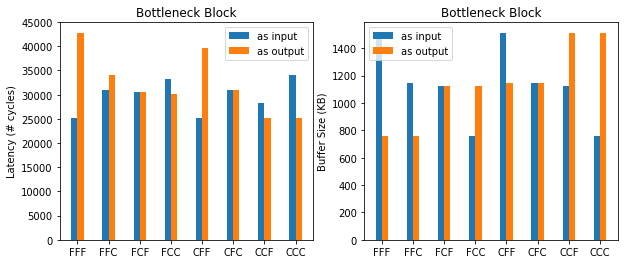

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

inp_plot_df = df[df['IsBufInput'] == True]
out_plot_df = df[df['IsBufInput'] == False]

ind = np.arange(len(inp_plot_df.index))
width = 0.2

ax[0].bar(ind, inp_plot_df['Throughput'].tolist(), width, label='as input')
ax[0].bar(ind + width, out_plot_df['Throughput'].tolist(), width, label='as output')
ax[0].set_ylabel('Latency (# cycles)')
ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(inp_plot_df['SEQ'].tolist())
ax[0].set_title('Bottleneck Block')
ax[0].legend()

ax[1].bar(ind, inp_plot_df['BufferSize'].tolist(), width, label='as input')
ax[1].bar(ind + width, out_plot_df['BufferSize'].tolist(), width, label='as output')
ax[1].set_ylabel('Buffer Size (KB)')
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(inp_plot_df['SEQ'].tolist())
ax[1].set_title('Bottleneck Block')
ax[1].legend()

#### Stacked Block Example

In [57]:
SEQ = [utils.FILTER, utils.CHANNEL]
def encode_seq(seq):
    return ''.join([s[0].upper() for s in seq])
SEQS = list(itertools.product(SEQ, SEQ))
df = pd.DataFrame(columns=['SEQ', 'Cycles', 'Throughput', 'IsBufInput', 'BufferSize'])

P_Ws = [1]
P_C0s = [32]
P_C1s = [32]
P_Fs = [32]
PPs = list(itertools.product(P_Ws, P_C0s, P_C1s, P_Fs))

blocks = [
    create_stacked_block(56, 56, 64, 3)
]
for is_buf_input in [True, False]:
    for block in blocks:
        for seq in SEQS:
            for P_W, P_C0, P_C1, P_F in PPs:
                r = utils.run_dataflow_sim(3,
                                       block,
                                       {"conv1": {"P_W": P_W, "P_C": P_C0, "P_F": P_C1},
                                        "conv2": {"P_W": P_W, "P_C": P_C1, "P_F": P_F}},
                                       seq,
                                       is_buf_input=is_buf_input)

                throughput = r[0][-1] - r[0][-2]
                buffer_size = r[1] * 32 / 8 / 1024
                df = df.append(
                    pd.DataFrame([[encode_seq(seq), r[0][-1], throughput, is_buf_input, buffer_size]],
                                 columns=['SEQ', 'Cycles', 'Throughput', 'IsBufInput', 'BufferSize']),
                    ignore_index=True)

                print("%s %e %10d %s" % (encode_seq(seq), buffer_size, throughput, r[0]))
df

FF 7.290000e+02      12545 [18374, 30919, 43464]
FC 3.645000e+02      12546 [15459, 28005, 40551]
CF 7.290000e+02      12545 [18374, 30919, 43464]
CC 3.645000e+02      15241 [18154, 33395, 48636]
FF 3.645000e+02      15461 [15459, 30920, 46381]
FC 3.645000e+02      12546 [15459, 28005, 40551]
CF 7.290000e+02      12545 [18374, 30919, 43464]
CC 7.290000e+02      12544 [18154, 30698, 43242]


,SEQ,Cycles,Throughput,IsBufInput,BufferSize
0,FF,43464,12545,True,729.0
1,FC,40551,12546,True,364.5
2,CF,43464,12545,True,729.0
3,CC,48636,15241,True,364.5
4,FF,46381,15461,False,364.5
5,FC,40551,12546,False,364.5
6,CF,43464,12545,False,729.0
7,CC,43242,12544,False,729.0


In [58]:
stck_df = df
df

,SEQ,Cycles,Throughput,IsBufInput,BufferSize
0,FF,43464,12545,True,729.0
1,FC,40551,12546,True,364.5
2,CF,43464,12545,True,729.0
3,CC,48636,15241,True,364.5
4,FF,46381,15461,False,364.5
5,FC,40551,12546,False,364.5
6,CF,43464,12545,False,729.0
7,CC,43242,12544,False,729.0


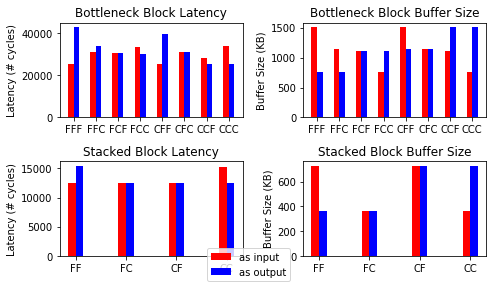

In [99]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 4))
names = ['Bottleneck', 'Stacked']
colors = 'rb'
widths = [0.25, 0.15]

for idx, df in enumerate([btnk_df, stck_df]):
    inp_plot_df = df[df['IsBufInput'] == True]
    out_plot_df = df[df['IsBufInput'] == False]

    ind = np.arange(len(inp_plot_df.index))
    width = widths[idx]

    ax[idx, 0].bar(ind, inp_plot_df['Throughput'].tolist(), width, label='as input', color=colors[0])
    ax[idx, 0].bar(ind + width, out_plot_df['Throughput'].tolist(), width, label='as output', color=colors[1])
    ax[idx, 0].set_ylabel('Latency (# cycles)')
    ax[idx, 0].set_xticks(ind + width / 2)
    ax[idx, 0].set_xticklabels(inp_plot_df['SEQ'].tolist())
    ax[idx, 0].set_title('%s Block Latency' % names[idx])    

    ax[idx, 1].bar(ind, inp_plot_df['BufferSize'].tolist(), width, label='as input', color=colors[0])
    ax[idx, 1].bar(ind + width, out_plot_df['BufferSize'].tolist(), width, label='as output', color=colors[1])
    ax[idx, 1].set_ylabel('Buffer Size (KB)')
    ax[idx, 1].set_xticks(ind + width / 2)
    ax[idx, 1].set_xticklabels(inp_plot_df['SEQ'].tolist())
    ax[idx, 1].set_title('%s Block Buffer Size' % names[idx])

plt.figlegend(['as input', 'as output'], loc='lower center')
fig.tight_layout()
fig.savefig('fusion_pipeline.pdf')